In [1]:
import pandas as pd
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from functools import reduce
from itertools import accumulate
from functools import wraps
from sklearn.datasets import make_classification
from mpl_toolkits.mplot3d import Axes3D 
import warnings
import math

In [2]:
warnings.filterwarnings("ignore")

In [3]:
import visualizacoes as vs
from utils import get_hyperplane, load_dataset, Classificador


### Função de custo do Perceptron

Até agora, demonstramos o perceptron simples usando a convenção mais atual para classificação binária, onde $y \in \left \{ 0,1 \right \}$. De fato, qualquer dataset de classificação binária que encontramos hoje ou, ao menos a esmagadora maioria deles, tem a variável alvo dessa forma, e sendo assim, conseguimos usar a step function como função de ativação do neurônio, que gera o output no range esperado. O algoritmo original de F. Rosenblatt foi idealizado com a função <em>signum</em> de "sinal", que retorna um output de -1 ou 1:

$$\normalsize \text{sign}(x) = \left\{\begin{matrix}1 & \text{se }wx + b \geqslant  0\\ -1 & \text{se }wx + b < 0\end{matrix}\right.$$

Sendo assim, o algoritmo de treino esperar uma variável resposta $y \in \left \{ -1,1 \right \}$. Com essa função de ativação, podemos chegar na mesma relação e algoritmo de aprendizado mostrado acima com uma pequena alteração no algoritmo: 

(1) $$\normalsize {w}' \leftarrow w + y_ix_i\,\,\, \text{   se }y_i \neq  \text{sign}(wx_i + b)$$


(2) $$\normalsize {b}' \leftarrow b + y_i \,\,\,\text{   se }y_i \neq  \text{sign}(wx_i + b)$$

E isso será equivalente a aplicar a equação que mostramos no caso de $y \in \left \{ 0,1 \right \}$. Se o erro for 0, não haverá atualizações, o que está de acordo com a regra do perceptron. Se houver falso positivo, significa que a classe real é $y_i = -1$ e assim a atualização do peso fica:

$$\normalsize {w}' = w + -1x = w - x $$

E se for falso negativo:

$$\normalsize {w}' = w + 1x = w + x $$

E porque estou falando isso agora? Um dos fatores que precisaremos definir, é qual função para contabilizar o erro utilizaremos para ajustar o modelo, e dentro deste racional, existem uma função de custo extremamente conveniente para se uitilizar caso estejamos trabalhando com o percentron original que retorna: $\hat{y} \in \left \{ -1,1 \right \}$. A função de custo em questão é uma adaptação do __Hinge Loss__ utilizada em SVMs:

$$\normalsize J(z_i) = \text{max}(0,\, - y_i(wx_i))$$

Repare que bias está contido no vetor de $w$, afinal é apenas um peso com input igual à 1. Para minimizar essa função com a descida de gradiente, precisamos computar o slope da função em respeito a cada um dos pesos $\normalsize \frac{\partial L}{\partial w_i}$. Observe que essa função é na verdade uma função composta por duas funções:

$$\normalsize J \Leftrightarrow  J(z) = \text{max}(0, - y_iz_i)$$

Onde $z(x_i) = wx_i$.

Se quisermos, podemos adaptar essa função para $y \in \left \{ 0,1 \right \}$ utilizando o termo $e = (y_i - \hat{y}_i)$ de maneira equivalente a utilizar o valor resposta $y_i$ se $y \in \left \{ -1,1 \right \}$.

$$\normalsize J \Leftrightarrow  J(z) = \text{max}(0, - e_iz_i)$$

Mas, para seguir a risca, acabamos transformando $y$ para o esperado pelo algoritmo original do perceptron e a função de hinge, de forma a simplificar a compreensão. 

In [4]:
hinge_perceptron = lambda x,y,w: max(0, -(y*x.dot(w)))

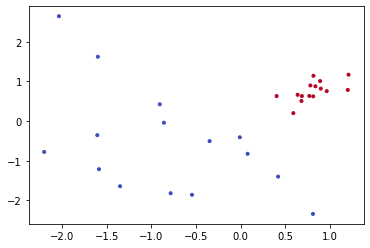

In [5]:
x, y = make_classification(
    n_samples=30, 
    n_features=2,
    n_redundant=0,
    class_sep=0.9,
    n_clusters_per_class=1,
    flip_y=0.00,
    random_state=6,
    n_classes=2
)
y = np.array([-1 if val == 0 else val for val in y])

vs.scatter_plot(x,y)

In [6]:
W = np.array([2, .1])

In [7]:
perceptron = lambda x: np.array([1 if z >= 0 else -1 for z in np.dot(x, W)])

In [8]:
clf = Classificador(perceptron)

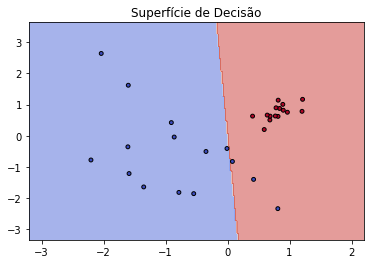

In [9]:
vs.plot_superficie_decisao(clf,x,y)

#### Porque usar essa função?

O racional por trás dessa função é bastante simples, mas ao mesmo tempo bem explicativo sobre o erro do modelo. Se a classificação do modelo estiver correta (ou seja, do lado correto do hiperplano), o sinal de $z_i$ será igual ao sinal de $y_i$. Como consequência, sabemos que o produto entre sinais iguais será sempre um valor positivo. Em ambos os casos - tanto para $y_i = -1$ e $z_i < 0$, quanto para $y_i = +1$ e $z_i \geq 0$ - a quantidade $yz$ será positiva, e quando multiplicada pelo $-1$ da função, o valor final será negativo, ou seja, menor que zero. Dessa forma, a função $\text{max}$ retornará 0, ou seja, erro 0 pois a classificação está correta.

Até aí, ela se comporta igual a contabilização do erro no perceptron original. Os casos de erro é que são interessantes! Para que a classificação esteja errada, o sinal de $y_i$ e $z_i$ será trocado correto? Ou seja, independente de qual for a classe certa e a previsão errada, o resultado da quantidade $yz$ será sempre negativo, que quando multiplicado por -1, resultará em um valor positivo. Dessa forma, para pontos erroneamente classificados, a função retornará a quantidade $wx$ (desconsideramos $y$ pois ele trata apenas do sinal). E olha que interessante, o que representa essa quantidade: __a distância para o hiperplano__! 

Ou seja, se o modelo acertar, o erro será zero. Se o modelo errar, o erro será proporcional a distância do ponto até o hiperplano, e isso é muito mais explicativo e melhor de se otimizar do que o erro simples que trabalhamos até então! Vamos pegar os 3 pontos classificados incorretamente pelo primeiro modelo, e calcular o erro para cada um deles

In [10]:
x_sample = np.array([val for val in x if val[0] > 0 and val[0] < 1 and val[1] <= 0])
y_sample = np.array([-1,-1,-1])
vs.display_matrix(x_sample)

<br>$\begin{bmatrix}0.81&-2.34\\0.08&-0.82\\0.42&-1.40\end{bmatrix}$<br><br>

Dimensões da matriz: (3 x 2)



In [11]:
erro_sample = [hinge_perceptron(x,y,W) for x,y in zip(x_sample, y_sample)]
vs.display_vec(erro_sample, 'J(\\theta)')

<br>$J(\theta) = \begin{bmatrix}1.39\\0.07\\0.70\end{bmatrix}$<br>

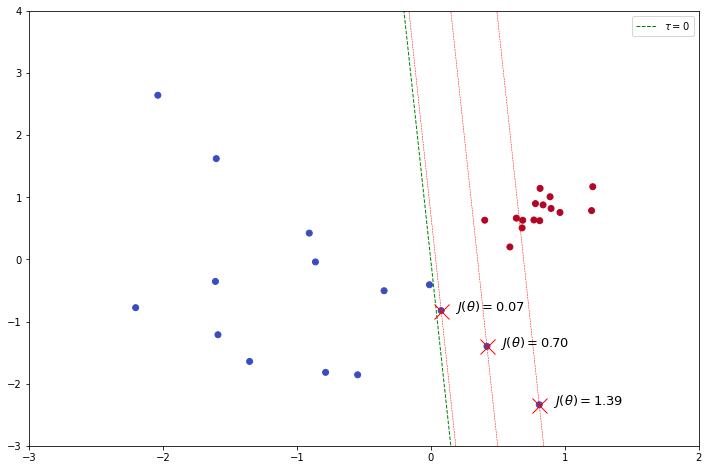

In [12]:
H = get_hyperplane(W, b=0, t=0)

plt.figure(figsize=(12,8))
plt.plot(np.linspace(-1,1,5), H(np.linspace(-1,1,5)), color='green', linewidth=1, linestyle='--', label='$\\tau = 0$')

for s, e in zip(x_sample, erro_sample):
    plt.plot(s[0], s[1], marker='x', markersize=15, color='red')
    h = get_hyperplane(W, b=0, t=e)
    plt.plot(np.linspace(-1,1,5), h(np.linspace(-1,1,5)), linewidth=.5, linestyle='--', color='red')
    plt.text(s[0] + 0.1, s[1], '$J(\\theta) = %.2f$' % e, fontsize=13)
        
plt.xlim(-3,2)
plt.ylim(-3,4)
plt.legend()
plt.scatter(x[:,0], x[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.show()

$$\normalsize J(\theta) = \sum_{i=1}^{N}\text{max}(0, - y_iz_i)$$

In [13]:
print('Erro nessa época: %.2f' % sum(erro_sample))

Erro nessa época: 2.16


#### Slope da função de custo

Podemos encontrar as derivadas parciais (uma para cada peso) através da regra da cadeia:

(1) $$\normalsize \frac{\partial L}{\partial w_i} = \frac{\partial L}{\partial z}\frac{\partial z}{w_i} $$

(2) $$\normalsize \frac{\partial L}{\partial z} = \frac{\partial}{\partial z} \text{max}(0, -y_iz) = \text{max}(0, -y_i)$$

(3) $$\normalsize \frac{\partial z}{\partial w_i} = \frac{\partial}{\partial w_i} w_ix = x$$

Juntando tudo:

(4) $$\normalsize \frac{\partial L}{\partial z}\frac{\partial z}{w_i} = \text{max}(0, -y_ix_i)$$

Dessa forma, teremos que a derivada parcial da função $L$ em respeito a $w$ será:

(5) $$\normalsize \frac{\partial L}{\partial w_i} = \left\{\begin{matrix}-yx & \text{se }yz <  0\\ 0 & \text{  caso contrário}\end{matrix}\right.$$

Observe no plot abaixo como a função se comporta para diferentes valores de $y_i z_i$. A função derivada encontrada acima fica intuitiva quando analisada contra o plot abaixo: Se a classificação do modelo estiver correta (ou seja, do lado correto do hiperplano), o sinal de $z_i$ será igual ao sinal de $y_i$. Como consequência, sabemos que o produto entre sinais iguais será um valor positivo

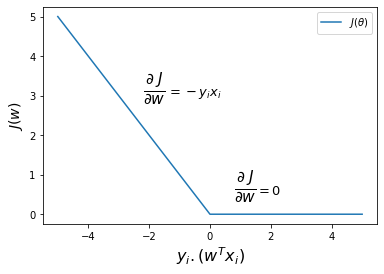

In [14]:
plt.plot(np.linspace(-5,5,5), [max(0, -v) for v in np.linspace(-5,5,5)], label='$J(\\theta)$')
plt.text(-2.2, 3, '$\\frac{\partial \,\,J}{\partial w}$', fontsize=22)
plt.text(-1.4, 3, '$= -y_ix_i$', fontsize=13)
plt.text(.8, .5, '$\\frac{\partial \,\,J}{\partial w}$', fontsize=22)
plt.text(1.5, .5, '$= 0$', fontsize=13)
plt.xlabel('$y_i . (w^Tx_i)$', fontsize=16)
plt.ylabel('$J(w)$', fontsize=14)
plt.legend()
plt.show()

In [15]:
def PerceptronLoss(x_i, y_i, W):
    erro = max(0, -(y_i*np.dot(x_i, W)))
    slope = (-y_i * x_i) * bool(erro)
    return erro, slope

Aplicando essa regra do delta no algoritmo de descida de gradiente estocástico, chegaremos em uma regra de atualização dos pesos bastante semelhante a do algoritmo original do perceptron. Caso tenhamos um erro, a atualização dos coeficientes será:

(7) $$\normalsize w^{t + 1} \leftarrow w^{t} - \eta \frac{\partial L}{\partial w} = w^{t} - \eta (-y_ix_i)$$

(8) $$\normalsize w^{t + 1} \leftarrow w^{t} + \eta (y_ix_i)$$

e o bias:

(8) $$\normalsize b^{t + 1} \leftarrow b^{t} + \eta (y_ix_i)$$

Caso não exista erro, o sub gradiente será 0, e os pesos não serão atualizados:

(9) $$\normalsize w^{t + 1} \leftarrow w^{t} - \eta (0) = w^{t}$$

(10) $$\normalsize b^{t + 1} \leftarrow b^{t}$$

In [74]:
class Perceptron:
        
    def __init__(self, W=None, b=None):
        self.W = W
        self.bias = b
        self.g = lambda x: np.array([1 if z >= 0 else 0 for z in x])
              
    def predict(self, X):
        if all(coef is None for coef in [self.W, self.bias]):
            raise('Necessário passar coeficientes ou treinar o modelo antes de realizar previsões')
        
        # valida se o input é uma lista. Se for, será convertida em numpy.array
        # A função de ativação self.g necessita recebe como argumento um interable
        X = np.array(X) if isinstance(X, list) else X        
        X = np.expand_dims(X, axis=0) if X.ndim == 1 else X
    
        # realiza a função de soma Z = WX + B e a ativação ativação g(WX + B)
        return self.g(np.dot(X, self.W) + self.bias)                
        
    def fit(self, X, Y, max_iters=100, lr_init=0.1, momentum=0.9, 
            decay=0.5, info=True, init_coefs=None, target_error=0.1, convert_Y=True):
        
        if convert_Y:
            Y = np.array([-1 if i == 0 else i for i in Y])
            
        n_samples, n_features = X.shape
        coefs = np.random.rand(n_features + 1) if init_coefs is None else init_coefs
        X_augmented = np.c_[np.ones(n_samples), X]       
        V_t = 0
        
        for t in range(1, max_iters + 1):           
            index = np.arange(n_samples)
            np.random.shuffle(index)
            n_t = lr_init / (1 + decay*t)
            erro_epoch = 0
            
            for x_i, y_i in zip(X_augmented[np.ix_(index,)], Y[index]):
                erro_i = max(0, -y_i*(x_i.dot(coefs)))
                gradiente_i = (-y_i * x_i) * bool(erro_i)
                V_t = -(momentum * V_t + n_t * gradiente_i)
                coefs += V_t
                erro_epoch += erro_i
            
            if erro_epoch <= target_error:
                break
                
            if (t % 2) != 0:
                print('Época: %d, Erro: %.2f' % (t, erro_epoch))
        
        self.bias = coefs[0]
        self.W = coefs[1:]

### Carregando dados para aplicação do algoritmo


In [75]:
X, Y = load_dataset()
Y = np.array([-1 if i == 0 else i for i in Y])

In [76]:
vs.display_matrix(X, n_rows=5)

<br>$\begin{bmatrix}0.41&0.68\\0.39&0.26\\0.23&0.04\\0.25&0.22\\0.34&0.54\end{bmatrix}$<br><br>

Dimensões da matriz: (1190 x 2)



In [77]:
vs.display_vec(Y[-5:])

<br>$\begin{bmatrix}-1\\-1\\-1\\-1\\-1\end{bmatrix}$<br>

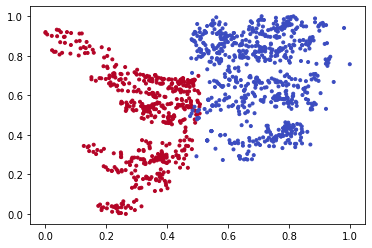

In [78]:
vs.scatter_plot(X, Y)

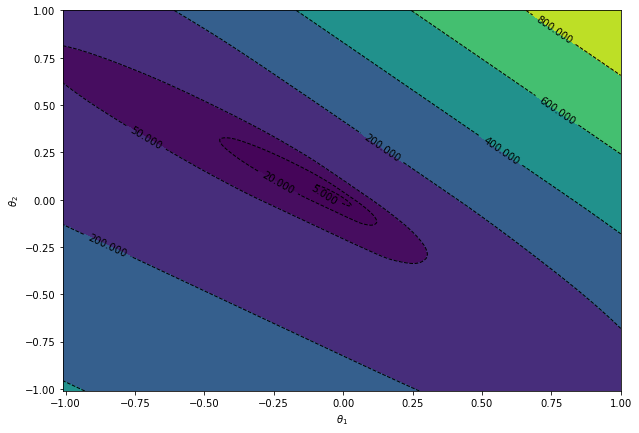

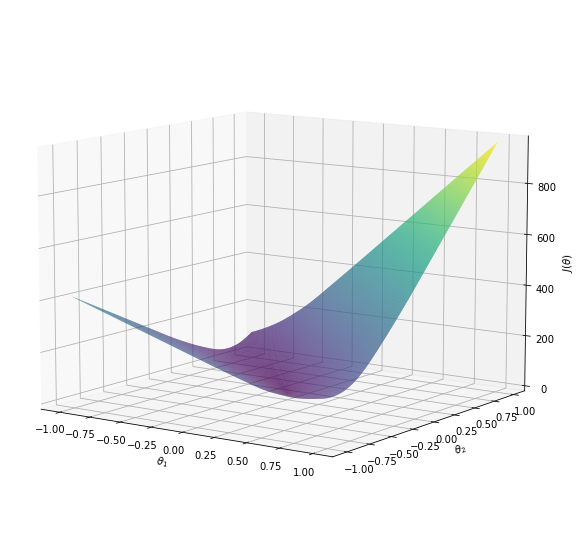

In [79]:
levels=[0, 5. , 20., 50., 200., 400., 600., 800., 1000.]
grid_w1, grid_w2, grid_w_space = vs.make_grid_space(-.01, .01, step=.01)
vals = [sum([max(0, yz_i) for yz_i in -Y * np.dot(X, W)]) for W in grid_w_space]
loss = np.array(vals).reshape(grid_w1.shape)
vs.plot_topographic(grid_w1, grid_w2, loss, show=False, levels=levels, size=(10,7))
vs.plot_3d_gradient(grid_w1, grid_w2, loss, angles=(10,-55), size=(12,10))

In [82]:
clf = Perceptron()

In [83]:
clf.fit(X, Y, lr_init=0.1, momentum=0.5, decay=0.9, target_error=0.11, convert_Y=False)

Época: 1, Erro: 21.53
Época: 3, Erro: 0.36
Época: 5, Erro: 0.28
Época: 7, Erro: 0.18
Época: 9, Erro: 0.18
Época: 11, Erro: 0.19
Época: 13, Erro: 0.17
Época: 15, Erro: 0.16
Época: 17, Erro: 0.15
Época: 19, Erro: 0.16
Época: 21, Erro: 0.14
Época: 23, Erro: 0.13
Época: 25, Erro: 0.11
Época: 27, Erro: 0.12
Época: 29, Erro: 0.12
Época: 31, Erro: 0.13
Época: 33, Erro: 0.13


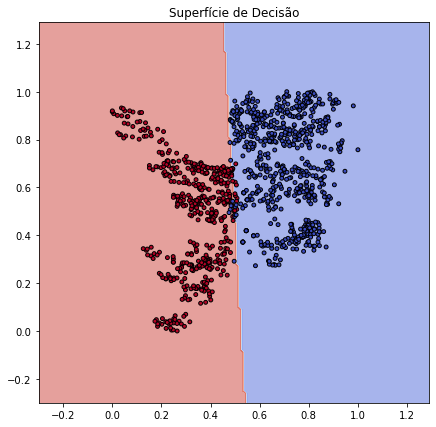

In [84]:
vs.plot_superficie_decisao(
    clf, X,Y, 
    limit_values=[(-.3, 1.3), (-.3, 1.3)], 
    size=(7,7), step=.01)